<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OOD detection
# DAN (Deep Averaging Network)
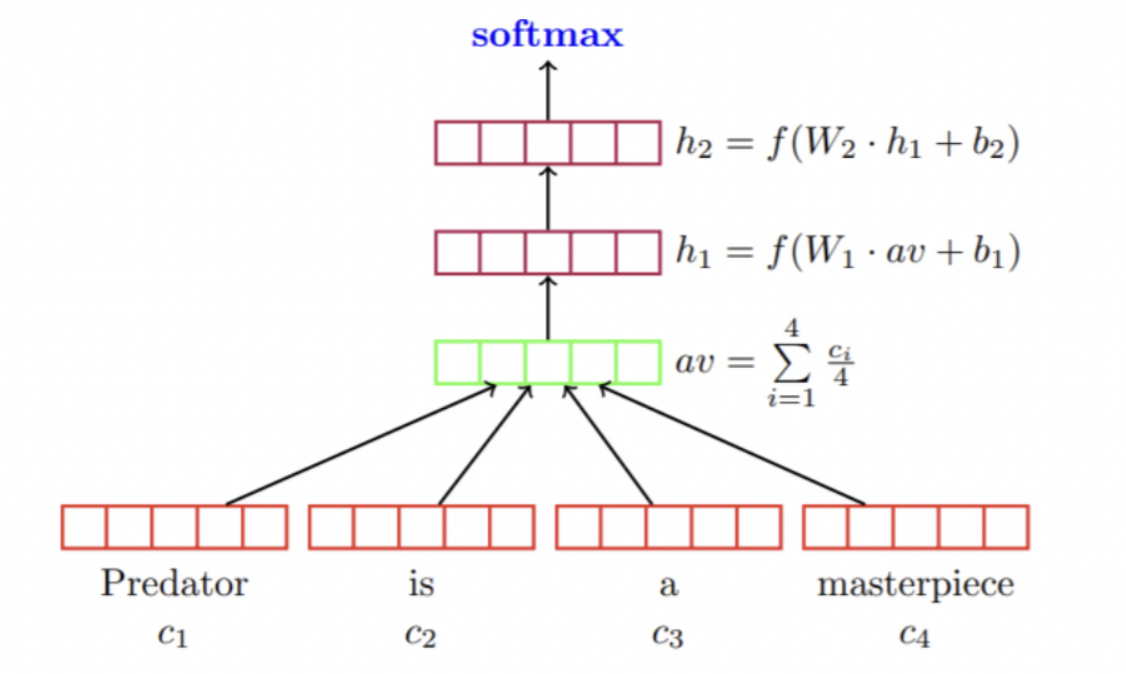

## Data Processing

### OOD classification 테스크를 위한 데이터 처리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install sentencepiece
!pip install pytorch-crf==0.4.0

In [8]:
import os
import sys
import json
import torch
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import trange

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

%cd /content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
from src.dataset import Preprocessing
from src.model import EpochLogger, MakeEmbed, save
%cd /root

/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
/root


In [10]:
class MakeDataset:
    def __init__(self):

        self.intent_ood_label_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/intent_label_with_ood.json"
        self.intent_data_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/intent_data.csv"
        self.ood_data_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/ood_data.csv"

        self.intent_ood_label = self.load_intent_ood_label()
        self.prep = Preprocessing()

    def load_intent_ood_label(self):
        f = open(self.intent_ood_label_dir, encoding="UTF-8")
        intent_ood_label = json.loads(f.read())
        self.intents_ood = list(intent_ood_label.keys())
        return intent_ood_label

    def tokenize(self, sentence):
        return sentence.split()

    def tokenize_dataset(self, dataset):
        token_dataset = []
        for data in dataset:
            token_dataset.append(self.tokenize(data))
        return token_dataset

    def make_ood_dataset(self, embed):
        intent_dataset = pd.read_csv(self.intent_data_dir)
        ood_dataset = pd.read_csv(self.ood_data_dir)#.sample(frac=1).reset_index(drop=True)
        intent_dataset = pd.concat([intent_dataset,ood_dataset])
        labels = []
        for label in intent_dataset["label"].to_list():
            if(label == "OOD"):
                labels.append(0)
            else:
                labels.append(1)

        intent_querys = self.tokenize_dataset(intent_dataset["question"].tolist())

        dataset = list(zip(intent_querys, labels))
        intent_train_dataset, intent_test_dataset = self.word2idx_dataset(dataset, embed)
        return intent_train_dataset, intent_test_dataset


    def word2idx_dataset(self, dataset ,embed, train_ratio = 0.8):
        embed_dataset = []
        question_list, label_list = [], []
        flag = True
        random.shuffle(dataset)
        for query, label in dataset :
            q_vec = embed.query2idx(query)
            q_vec = self.prep.pad_idx_sequencing(q_vec)

            question_list.append(torch.tensor([q_vec]))

            label_list.append(torch.tensor([label]))

        x = torch.cat(question_list)
        y = torch.cat(label_list)

        x_len = x.size()[0]
        y_len = y.size()[0]
        if(x_len == y_len):
            train_size = int(x_len*train_ratio)

            train_x = x[:train_size]
            train_y = y[:train_size]

            test_x = x[train_size+1:]
            test_y = y[train_size+1:]

            train_dataset = TensorDataset(train_x,train_y)
            test_dataset = TensorDataset(test_x,test_y)

            return train_dataset, test_dataset

        else:
            print("ERROR x!=y")



In [11]:
dataset = MakeDataset()

In [12]:
pd.read_csv(dataset.ood_data_dir)

,question,label
0,저기 그림 화면 그릴 거야,OOD
1,그림 틀어줄래,OOD
2,저기 있잖아 그림 좀,OOD
3,그림 그릴 거야,OOD
4,그림 켜줄래,OOD
...,...,...
12218,훔쳐보는 것 눈치 보임,OOD
12219,훔쳐보는 것 눈치 보임,OOD
12220,흑기사 해주는 짝남,OOD
12221,힘든 연애 좋은 연애라는게 무슨 차이일까,OOD


In [13]:
pd.read_csv(dataset.intent_data_dir)

,question,label
0,야 먼지 알려주겠니,dust
1,아니 먼지 정보 알려주세요,dust
2,그 때 미세먼지 어떨까,dust
3,그 때 먼지 좋으려나,dust
4,미세먼지 어떨 것 같은데,dust
...,...,...
19987,구미 날씨 덥니,weather
19988,영암 우산 가져갈까,weather
19989,군포 비오냐,weather
19990,하남 덥냐,weather


In [14]:
embed = MakeEmbed()
embed.load_word2vec()

batch_size = 128

ood_train_dataset, ood_test_dataset = dataset.make_ood_dataset(embed)

train_dataloader = DataLoader(ood_train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(ood_test_dataset, batch_size=batch_size, shuffle=True)

## Deep Unordered Composition Rivals Syntactic Methods for Text Classification
### * Iyyer
### tensorflow code(tf-hub로 제공) : https://tfhub.dev/google/universal-sentence-encoder/4
### keras code : https://github.com/candlewill/Vecamend-master2/blob/master/dan.py#L41

In [15]:
class DAN(nn.Module):

    def __init__(self, w2v, dim, dropout, num_class = 2):
        super(DAN, self).__init__()
        #load pretrained embedding in embedding layer.
        vocab_size = w2v.size()[0]
        emb_dim = w2v.size()[1]
        self.embed = nn.Embedding(vocab_size+2, emb_dim)
        self.embed.weight[2:].data.copy_(w2v)
        #self.embed.weight.requires_grad = False

        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(emb_dim)
        self.fc1 = nn.Linear(emb_dim, dim)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, num_class)

    def forward(self, x):
        emb_x = self.embed(x)
        #(128,20,300)
        x = emb_x.mean(dim=1)
        #(128,300)
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.fc1(x)
        #(128,256)
        x = self.dropout2(x)
        x = self.bn2(x)
        logit = self.fc2(x)
        #(128,2 )
        return logit

In [16]:
weights = embed.word2vec.wv.vectors
weights = torch.FloatTensor(weights)

model = DAN(weights, 256, 0.5, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

DAN(
  (embed): Embedding(1481, 300)
  (dropout1): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

## Training

In [17]:
epoch = 5
prev_acc = 0
save_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/1_ood_clsf_model//"
save_prefix = "ood_clsf"
for i in range(epoch):
    steps = 0
    model.train()
    #for data in train_dataloader:
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {i}")
            x = data[0]
            target = data[1]
            logit = model.forward(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(logit, target)
            loss.backward()
            optimizer.step()

            corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
            accuracy = 100.0 * corrects/x.size()[0]
            tepoch.set_postfix(loss=loss.item(), accuracy= accuracy.numpy())

    model.eval()
    steps = 0
    accuarcy_list = []
    #for data in test_dataloader:
    with tqdm(test_dataloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {i}")
            x = data[0]
            target = data[1]

            logit = model.forward(x)
            loss = F.cross_entropy(logit, target)
            corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
            accuracy = 100.0 * corrects/x.size()[0]
            accuarcy_list.append(accuracy.tolist())

            tepoch.set_postfix(loss=loss.item(), accuracy= sum(accuarcy_list)/len(accuarcy_list))

    acc = sum(accuarcy_list)/len(accuarcy_list)
    if(acc>prev_acc):
        prev_acc = acc
        save(model, save_dir, save_prefix+"_"+str(round(acc,3)), i)

Epoch 4: 100%|██████████| 51/51 [00:00<00:00, 109.57batch/s, accuracy=99.5, loss=0.000777]


In [18]:
## Load & test

In [19]:
model.load_state_dict(torch.load("/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_ood_clsf_model/ood_clsf_99.724_steps_5.pt"))

model.eval()

DAN(
  (embed): Embedding(1481, 300)
  (dropout1): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [20]:
%%time
q = "제주도"

x = dataset.prep.pad_idx_sequencing(embed.query2idx(dataset.tokenize(q)))

x = torch.tensor(x)
f = model(x.unsqueeze(0))

y = torch.argmax(f).tolist()

print("발화 : " + q)
if(not y):
    print("ood")
else:
    print("intent")


발화 : 제주도
ood
CPU times: user 4.06 ms, sys: 0 ns, total: 4.06 ms
Wall time: 15.4 ms


In [21]:
%%time
q = "제주도 날씨"

x = dataset.prep.pad_idx_sequencing(embed.query2idx(dataset.tokenize(q)))

x = torch.tensor(x)
f = model(x.unsqueeze(0))

y = torch.argmax(f).tolist()

print("발화 : " + q)
if(not y):
    print("ood")
else:
    print("intent")


발화 : 제주도 날씨
intent
CPU times: user 3.74 ms, sys: 2 µs, total: 3.74 ms
Wall time: 14.9 ms
